In [33]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

DATA_PATH = Path().cwd().parent / "data"


def read_data(file_name):
    return pd.read_csv(DATA_PATH / file_name, parse_dates=True)


shipments_df = read_data("shipments.csv")
po_df = read_data("purchase_orders.csv")
suppliers_df = read_data("suppliers.csv")
skus_df = read_data("skus.csv")
transit_events_df = read_data("transit_events.csv")
sites_df = read_data("sites.csv")
deployments_df = read_data("deployments.csv")
rma_df = read_data("rma_returns.csv")
inventory_df = read_data("inventory_snapshots.csv")
_datetime_map = {
    "shipments": (shipments_df, ["ship_date", "eta_date", "actual_delivery_date"]),
    "purchase_orders": (po_df, ["order_date", "promised_date"]),
    "transit_events": (transit_events_df, ["event_ts"]),
}
for _, (df, cols) in _datetime_map.items():
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")

Detect sites with abnormal failure rates (RMA spike detection).

In [34]:
rma_df['rma_date'] = pd.to_datetime(rma_df['rma_date'])

# 2. Aggregate: Create Weekly Time Series
# ---------------------------------------
# Group by Site and Week (W-MON = Weekly starting Monday)
weekly_ts = (
    rma_df
    .groupby(['site_id', pd.Grouper(key='rma_date', freq='W-MON')])
    .size()
    .reset_index(name='rma_count')
    .sort_values(['site_id', 'rma_date'])
)
weekly_ts

,site_id,rma_date,rma_count
0,ST-00001,2023-01-09,1
1,ST-00001,2023-02-20,1
2,ST-00001,2023-04-03,1
3,ST-00001,2023-04-24,1
4,ST-00001,2023-05-01,1
...,...,...,...
37365,ST-02000,2023-11-20,1
37366,ST-02000,2024-06-10,1
37367,ST-02000,2024-06-24,1
37368,ST-02000,2024-07-01,1


In [35]:
grouped_rolling = weekly_ts.groupby('site_id')['rma_count'].rolling(window=8, min_periods=1)

# Calculate Mean and Std, shift by 1 to use *historical* data for the baseline
weekly_ts['rolling_mean'] = weekly_ts.groupby('site_id')['rma_count'].shift(1).rolling(8, min_periods=1).mean().reset_index(0, drop=True)
weekly_ts['rolling_std'] = weekly_ts.groupby('site_id')['rma_count'].shift(1).rolling(8, min_periods=1).std().reset_index(0, drop=True)

# Handle division by zero or NaN std (replace 0 with a small epsilon or 1)
weekly_ts['rolling_std'] = weekly_ts['rolling_std'].fillna(1).replace(0, 1)
weekly_ts['rolling_mean'] = weekly_ts['rolling_mean'].fillna(0)

weekly_ts

,site_id,rma_date,rma_count,rolling_mean,rolling_std
0,ST-00001,2023-01-09,1,0.000,1.000000
1,ST-00001,2023-02-20,1,1.000,1.000000
2,ST-00001,2023-04-03,1,1.000,1.000000
3,ST-00001,2023-04-24,1,1.000,1.000000
4,ST-00001,2023-05-01,1,1.000,1.000000
...,...,...,...,...,...
37365,ST-02000,2023-11-20,1,1.125,0.353553
37366,ST-02000,2024-06-10,1,1.125,0.353553
37367,ST-02000,2024-06-24,1,1.000,1.000000
37368,ST-02000,2024-07-01,1,1.000,1.000000


In [36]:
weekly_ts['z_score'] = (weekly_ts['rma_count'] - weekly_ts['rolling_mean']) / weekly_ts['rolling_std']


In [37]:
anomalies = weekly_ts[
    (weekly_ts['z_score'] > 1.5) & 
    (weekly_ts['rma_count'] >= 2)
].copy()
anomalies = anomalies.merge(sites_df[['site_id', 'region', 'site_type', 'country']], on='site_id', how='left')
anomalies

,site_id,rma_date,rma_count,rolling_mean,rolling_std,z_score,region,site_type,country
0,ST-00001,2025-03-17,2,1.125000,0.353553,2.474874,EMEA,Cell Site,Italy
1,ST-00001,2025-09-22,2,1.125000,0.353553,2.474874,EMEA,Cell Site,Italy
2,ST-00002,2024-01-15,2,1.125000,0.353553,2.474874,APAC,Cell Site,South Korea
3,ST-00002,2024-01-22,2,1.250000,0.462910,1.620185,APAC,Cell Site,South Korea
4,ST-00002,2025-08-18,2,1.250000,0.462910,1.620185,APAC,Cell Site,South Korea
...,...,...,...,...,...,...,...,...,...
947,ST-01996,2024-04-22,2,1.142857,0.377964,2.267787,EMEA,Cell Site,Germany
948,ST-01998,2023-12-11,2,1.142857,0.377964,2.267787,APAC,Cell Site,Indonesia
949,ST-01999,2024-04-08,2,1.125000,0.353553,2.474874,AMER,Warehouse,Chile
950,ST-01999,2024-12-02,2,1.250000,0.462910,1.620185,AMER,Warehouse,Chile


In [38]:
anomalies = anomalies.sort_values('z_score', ascending=False)

print(f"Detected {len(anomalies)} anomalous spikes.")
anomalies

Detected 952 anomalous spikes.


,site_id,rma_date,rma_count,rolling_mean,rolling_std,z_score,region,site_type,country
665,ST-01400,2025-06-16,4,1.125,0.353553,8.131728,AMER,Cell Site,Argentina
838,ST-01729,2025-05-05,4,1.250,0.462910,5.940679,EMEA,Cell Site,Germany
420,ST-00858,2025-01-27,3,1.125,0.353553,5.303301,EMEA,Cell Site,Italy
922,ST-01940,2025-01-20,3,1.125,0.353553,5.303301,APAC,Cell Site,Indonesia
392,ST-00806,2024-04-08,3,1.125,0.353553,5.303301,APAC,Warehouse,India
...,...,...,...,...,...,...,...,...,...
26,ST-00071,2025-06-23,2,1.250,0.462910,1.620185,AMER,Cell Site,Mexico
3,ST-00002,2024-01-22,2,1.250,0.462910,1.620185,APAC,Cell Site,South Korea
4,ST-00002,2025-08-18,2,1.250,0.462910,1.620185,APAC,Cell Site,South Korea
18,ST-00061,2024-12-16,2,1.250,0.462910,1.620185,EMEA,Cell Site,Italy


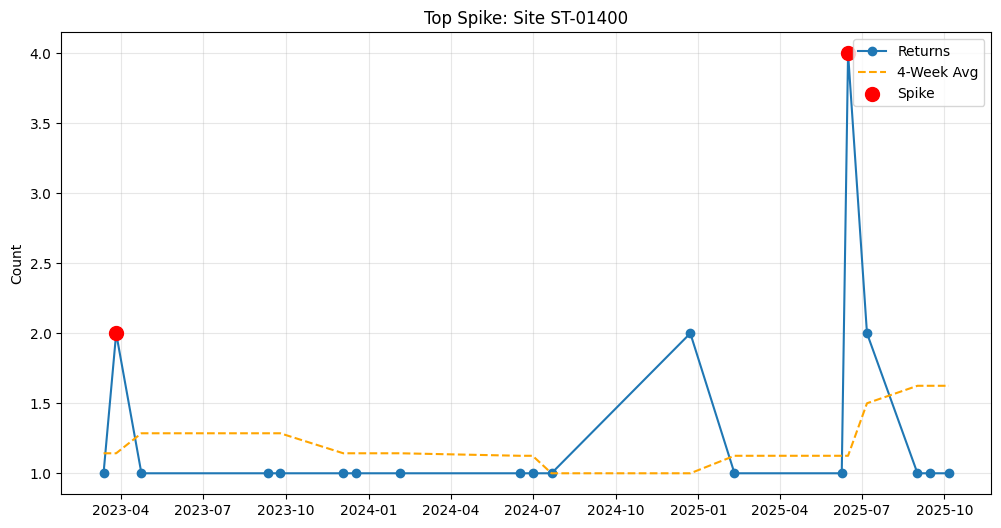

In [39]:
top_site = anomalies.iloc[0]['site_id']
site_data = weekly_ts[weekly_ts['site_id'] == top_site]

plt.figure(figsize=(12, 6))
plt.plot(site_data['rma_date'], site_data['rma_count'], marker='o', label='Returns')
plt.plot(site_data['rma_date'], site_data['rolling_mean'], linestyle='--', color='orange', label='4-Week Avg')

# Highlight anomalies
site_anoms = anomalies[anomalies['site_id'] == top_site]
plt.scatter(site_anoms['rma_date'], site_anoms['rma_count'], color='red', s=100, zorder=5, label='Spike')

plt.title(f"Top Spike: Site {top_site}")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [40]:
# Drill down into the identified anomalies to find the root cause (Top SKU & Reason)
print(f"--- Root Cause Analysis for Top 5 Spikes ---\n")

for index, row in anomalies.head(5).iterrows():
    site = row['site_id']
    spike_date = row['rma_date']
    
    # Define the week window (since we aggregated by W-MON)
    week_end = spike_date + pd.Timedelta(days=6)
    
    # Filter raw data for this specific site and week
    spike_details = rma_df[
        (rma_df['site_id'] == site) & 
        (rma_df['rma_date'] >= spike_date) & 
        (rma_df['rma_date'] <= week_end)
    ]
    
    # Find culprits
    top_reason = spike_details['reason_code'].mode()[0] if not spike_details.empty else "N/A"
    top_sku = spike_details['sku_id'].mode()[0] if not spike_details.empty else "N/A"
    
    print(f"Site: {site} | Week: {spike_date.date()} | Spiked Volume: {row['rma_count']}")
    print(f"  > Primary Failure Mode: {top_reason}")
    print(f"  > Problematic SKU:      {top_sku}\n")

--- Root Cause Analysis for Top 5 Spikes ---

Site: ST-01400 | Week: 2025-06-16 | Spiked Volume: 4
  > Primary Failure Mode: RF_FAULT
  > Problematic SKU:      SKU-03811

Site: ST-01729 | Week: 2025-05-05 | Spiked Volume: 4
  > Primary Failure Mode: DOA
  > Problematic SKU:      SKU-00140

Site: ST-00858 | Week: 2025-01-27 | Spiked Volume: 3
  > Primary Failure Mode: INTERMITTENT
  > Problematic SKU:      SKU-01475

Site: ST-01940 | Week: 2025-01-20 | Spiked Volume: 3
  > Primary Failure Mode: N/A
  > Problematic SKU:      N/A

Site: ST-00806 | Week: 2024-04-08 | Spiked Volume: 3
  > Primary Failure Mode: N/A
  > Problematic SKU:      N/A



In [41]:
# Enrich RMA data with SKU and Site metadata for correlation analysis
rich_rma_df = (
    rma_df
    .merge(skus_df[['sku_id', 'vendor', 'category', 'technology']], on='sku_id', how='left')
    .merge(sites_df[['site_id', 'region', 'site_type']], on='site_id', how='left')
)

print(f"Enriched shape: {rich_rma_df.shape}")
rich_rma_df.head()

Enriched shape: (40000, 11)


,rma_id,sku_id,site_id,reason_code,rma_date,under_warranty,vendor,category,technology,region,site_type
0,RMA-0000001,SKU-00206,ST-01094,DOA,2024-10-15,True,ZTE,Power,Dual (4G/5G),APAC,Integration Center
1,RMA-0000002,SKU-02303,ST-01174,RF_FAULT,2023-11-05,False,Nokia,RAN,4G,EMEA,Cell Site
2,RMA-0000003,SKU-04015,ST-01643,RF_FAULT,2025-03-26,True,Juniper,Antenna,Dual (4G/5G),EMEA,Warehouse
3,RMA-0000004,SKU-00438,ST-01539,DOA,2025-02-25,True,Samsung,Edge Router,4G,EMEA,Cell Site
4,RMA-0000005,SKU-02819,ST-00776,MECH_DAMAGE,2023-06-02,True,HPE Aruba,RAN,4G,EMEA,Warehouse


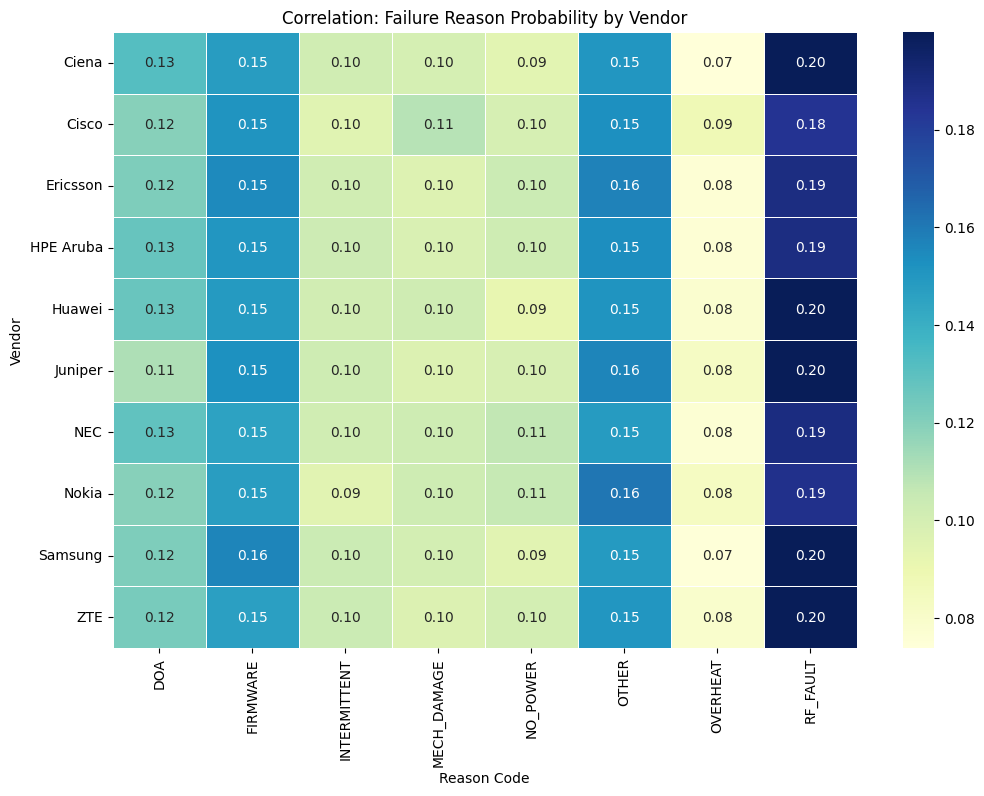

In [42]:
vendor_reason_corr = pd.crosstab(
    rich_rma_df['vendor'], 
    rich_rma_df['reason_code'], 
    normalize='index'
)

plt.figure(figsize=(12, 8))
sns.heatmap(vendor_reason_corr, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title("Correlation: Failure Reason Probability by Vendor")
plt.ylabel("Vendor")
plt.xlabel("Reason Code")
plt.show()

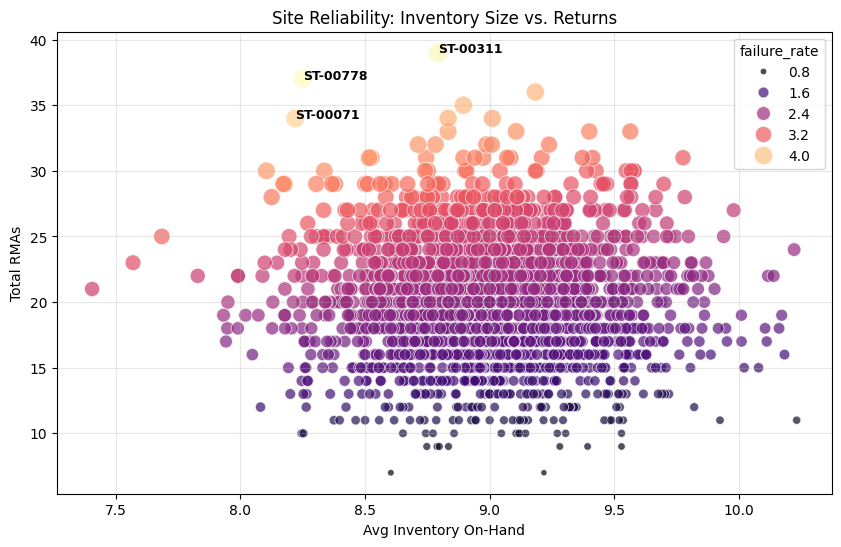

,site_id,total_returns,avg_inventory,failure_rate
777,ST-00778,37,8.250000,4.484848
310,ST-00311,39,8.793814,4.434936
70,ST-00071,34,8.219780,4.136364


In [43]:
# 1. Estimate Site Size (Average Inventory Level)
site_size = inventory_df.groupby('site_id')['on_hand_qty'].mean().reset_index(name='avg_inventory')

# 2. Count Total RMAs per site
total_rmas = rma_df.groupby('site_id').size().reset_index(name='total_returns')

# 3. Merge and Calculate Rate
site_health = pd.merge(total_rmas, site_size, on='site_id', how='inner')

# Handle sites with 0 inventory records (avoid division by zero)
site_health['avg_inventory'] = site_health['avg_inventory'].replace(0, 1) 

# Calculate Failure Rate (Returns per unit of inventory)
site_health['failure_rate'] = site_health['total_returns'] / site_health['avg_inventory']

# 4. Visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=site_health, 
    x='avg_inventory', 
    y='total_returns', 
    hue='failure_rate',
    palette='magma',
    size='failure_rate',
    sizes=(20, 200),
    alpha=0.7
)
plt.title("Site Reliability: Inventory Size vs. Returns")
plt.xlabel("Avg Inventory On-Hand")
plt.ylabel("Total RMAs")
plt.grid(True, alpha=0.3)

# Label top 3 worst failure rates
top_fails = site_health.sort_values('failure_rate', ascending=False).head(3)
for _, row in top_fails.iterrows():
    plt.text(row['avg_inventory'], row['total_returns'], row['site_id'], fontsize=9, weight='bold')

plt.show()

# Show the data for the worst sites
top_fails